In [1]:
import os
import numpy as np
import pandas as pd
import time
from pathlib import Path

%pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

%pip install tensorflow
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(16) 
tf.config.threading.set_inter_op_parallelism_threads(16)
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, SeparableConv2D
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import layers

%pip install scikit-learn 
from sklearn import metrics

import matplotlib.pyplot as plt
%pip install seaborn 
import seaborn as sns
sns.set()

  Preparing metadata (setup.py) ... - done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.3-py3-none-any.whl size=6749 sha256=1cab7055d2615c03cb40acdd31692d96ea40242a87b2eb7d7f4853db137ee6f3
  Stored in directory: /home/azureuser/.cache/pip/wheels/3b/56/66/0a24f17491d94dca2102ee05c2af8eb7d2113d59974f2fa49d
Successfully built silence_tensorflow
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.2 MB/s eta 0:00:0000:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.0
    Uninstalling ml_dtypes-0.5.0:
      Successfully uninstalled ml_dtypes-0.5.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
### Download dataset from kagglehub
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.
Path to dataset files: /home/azureuser/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


 83%|████████▎ | 268M/325M [00:02<00:00, 202MB/s]  


In [3]:
train_dir = path + '/train/'
test_dir = path + '/test/'
print("Path to dataset files:", path)

Path to dataset files: /home/azureuser/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


(224, 224)

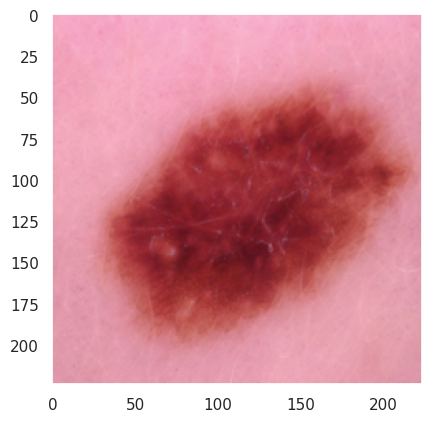

In [4]:
## Visualize a random image in benign dir
import os
random_number = np.random.randint(1000)

train_figure_name = os.listdir(train_dir + 'benign')[random_number]
full_name_train = train_dir + 'benign' + '/' + train_figure_name
image = load_img(full_name_train)
#display(image)
plt.imshow(image)
plt.grid(False)
image.size

In [8]:
#Genenrate image data sets for training, validation and test
image_size = (224, 224)
batch_size = 32

augmented_train_gen = ImageDataGenerator(
    rotation_range=30,
    brightness_range=[0.9,1.1],
    zoom_range=0.1,
    fill_mode='constant',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    validation_split=0.2
)

validation_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    rescale=1./255
)

### training dataset

augmented_train_generator = augmented_train_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

augmented_validation_generator = validation_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

augmented_test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

for gen, name in zip([augmented_train_generator, augmented_validation_generator, augmented_test_generator],
                     ['train', 'validation', 'test']):
    count_malignant = (gen.classes==1).sum()
    count_benign = (gen.classes==0).sum()
    tot = len(gen.classes)
    print(f"Class distribution in the {name} set")
    print(f"Benign: {count_benign/tot:.0%}")
    print(f"Malignant: {count_malignant/tot:.0%}\n")

#### Define metrics

model_metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'),
]

output_bias = -np.log(count_malignant/count_benign)
print('Initial output bias:', output_bias)
output_bias = tf.keras.initializers.Constant(output_bias)

input_bias = -np.log(1/2)
print('Initiali output bias:', input_bias)
input_bias = tf.keras.initializers.Constant(input_bias)


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Class distribution in the train set
Benign: 55%
Malignant: 45%

Class distribution in the validation set
Benign: 55%
Malignant: 45%

Class distribution in the test set
Benign: 55%
Malignant: 45%

Initial output bias: 0.1823215567939546
Initiali output bias: 0.6931471805599453


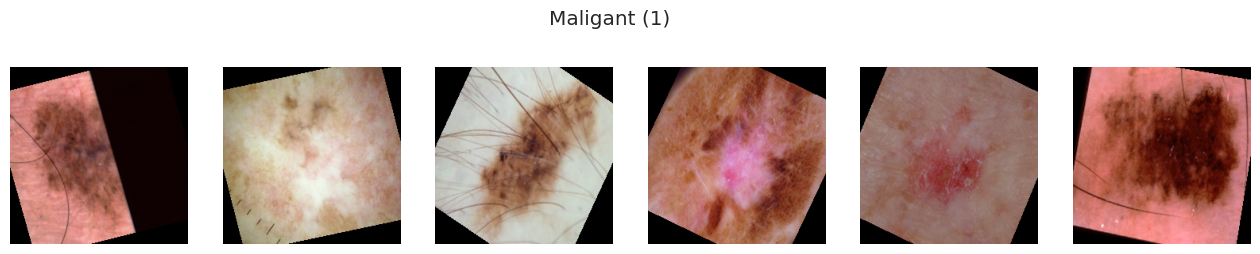

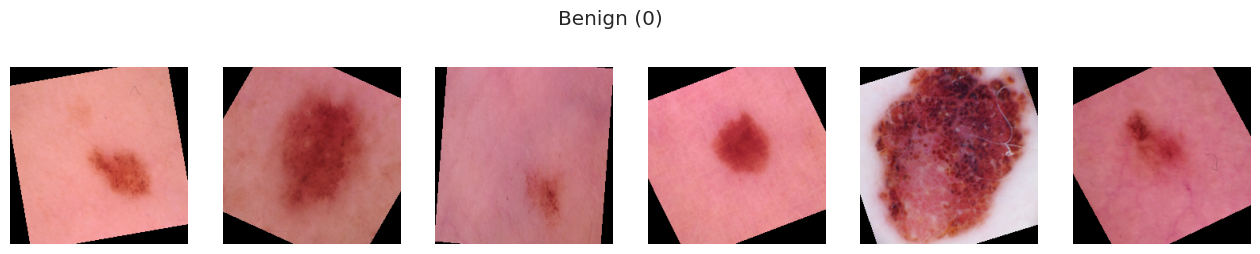

In [9]:
### visualize some images

for images, labels in augmented_train_generator:
    malignant_set = [{'image':image, 'label':label} for image, label in zip(images, labels) if label==1]
    benign_set = [{'image':image, 'label':label} for image, label in zip (images, labels) if label==0]

    break

for image_label in malignant_set[:6], benign_set[:6]:
  plt.figure(figsize=(16,3))
  plt.suptitle('Maligant (1)' if int(image_label[0]['label'])==1 else 'Benign (0)')
  for i in range(int(len(malignant_set[:6]))):
    plt.subplot(1, int(len(malignant_set[:6])), i+1)
    plt.imshow(image_label[i]['image'])
    plt.axis('off')
  plt.show()



In [10]:
pre_trained_Xception = keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(None,None,3)
)

pre_trained_Xception.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer[0][0] │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [11]:
### Change the model by setting trainable layers in Xception

pre_trained_Xception.trainable = True

for layer in pre_trained_Xception.layers:
  if 'block14_' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False


input_tensor = keras.Input(shape=(image_size+(3,)), name='input')
x = pre_trained_Xception(input_tensor)
x = keras.layers.Flatten(name='flatten')(x)
x = keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal')(x)
output = keras.layers.Dense(1, activation='sigmoid', name='output', bias_initializer=output_bias)(x)

fine_turned_xception_model = keras.Model(inputs=input_tensor, outputs=output, name='fine_turned_xception_model')
fine_turned_xception_model.summary()



Model: "fine_turned_xception_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │     1,605,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,467,145 (85.71 MB)

 Trainable params: 6,354,465 (24.24 MB)

 Non-trainable params: 16,112,680 (61.46 MB)

In [12]:
### callback function
model_dir = 'Users/lenhanpham/model_dir'
os.makedirs(model_dir, exist_ok=True)
csv_dir = 'Users/lenhanpham/csv_dir'
os.makedirs(csv_dir, exist_ok=True)

def callbacks(model_name, append_csv=False):
  callb = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath = model_dir + '/' + model_name + '.keras',
          monitor='val_auc',
          save_best_only=True,
          mode='max'
      ),
      tf.keras.callbacks.EarlyStopping(
          monitor='val_auc',
          patience=10,
          mode='max',
          restore_best_weights=True
      ),
      tf.keras.callbacks.CSVLogger(
          filename=csv_dir + '/' + model_name + '.csv',
          separator=',',
          append=append_csv
      )
  ]
  return callb

In [13]:
### compile the model and train it

fine_turned_xception_model.compile(loss='binary_crossentropy',
                                   optimizer=keras.optimizers.Adam(learning_rate=2e-5),
                                   metrics=model_metrics,
                                   )

fine_turned_xception_model_history = fine_turned_xception_model.fit(augmented_train_generator,
                                                                    validation_data=augmented_validation_generator,
                                                                    callbacks=callbacks('fine_turned_xception_model'),
                                                                    epochs=50)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 881ms/step - accuracy: 0.6317 - auc: 0.6802 - fn: 208.0448 - fp: 144.5522 - loss: 0.6305 - precision: 0.6009 - recall: 0.5290 - tn: 450.3582 - tp: 283.3433 - val_accuracy: 0.7514 - val_auc: 0.8331 - val_fn: 79.0000 - val_fp: 52.0000 - val_loss: 0.5181 - val_precision: 0.7547 - val_recall: 0.6695 - val_tn: 236.0000 - val_tp: 160.0000
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 852ms/step - accuracy: 0.7857 - auc: 0.8741 - fn: 123.0746 - fp: 101.2537 - loss: 0.4514 - precision: 0.7813 - recall: 0.7390 - tn: 484.9552 - tp: 376.6269 - val_accuracy: 0.7438 - val_auc: 0.8478 - val_fn: 104.0000 - val_fp: 31.0000 - val_loss: 0.5029 - val_precision: 0.8133 - val_recall: 0.5649 - val_tn: 257.0000 - val_tp: 135.0000
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 853ms/step - accuracy: 0.8235 - auc: 0.8978 - fn: 88.7015 - fp: 99.0299 - loss: 0.4082 - precision: 0.8128 - recall: 0.8062 - tn: 487.4328 - tp: 411.4925 - val_accuracy: 0.7818 - val_auc: 0.8610

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


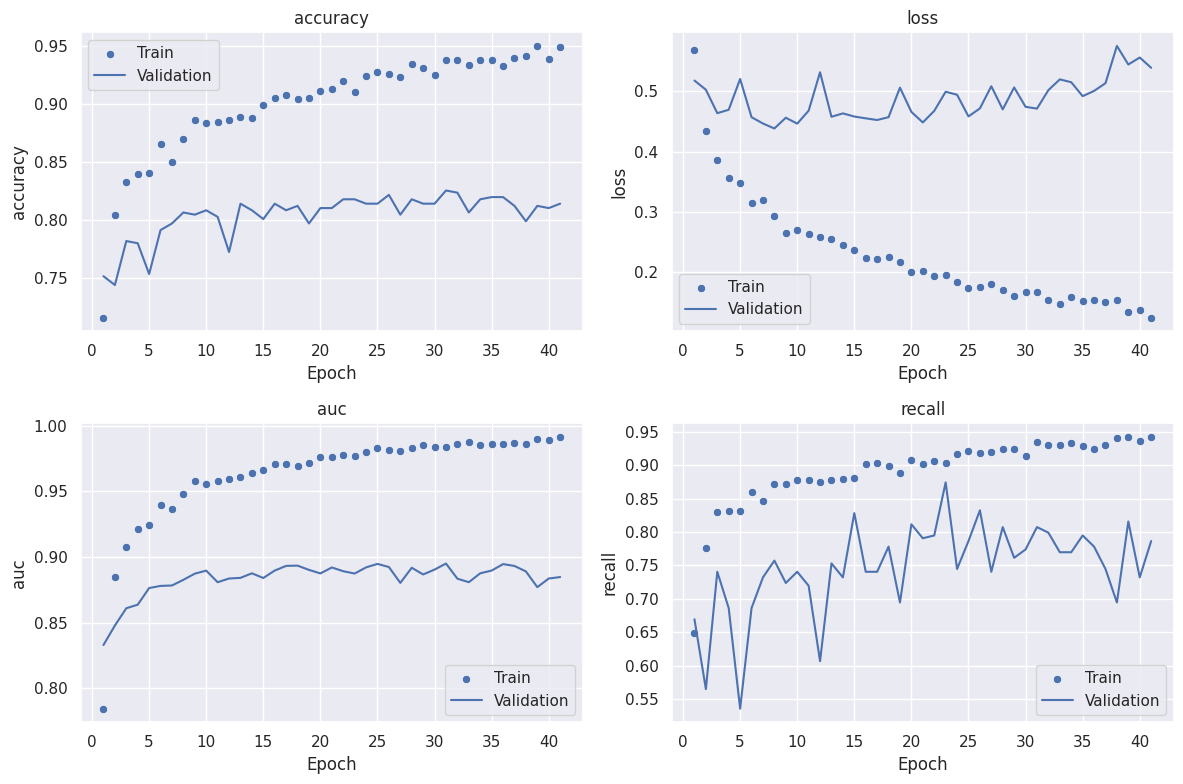

In [16]:
def plot_training_history(metrics, hist_dict):
  epochs = range(1, len(hist_dict[metrics])+1)
  sns.scatterplot(x=epochs, y=hist_dict[metrics])
  sns.lineplot(x=epochs,y= hist_dict['val_'+metrics])
  plt.title(metrics)
  plt.xlabel('Epoch')
  plt.ylabel(metrics)
  plt.legend(['Train', 'Validation'])

def plot_4metrics(hist_dict):
  plt.figure(figsize=(12,8))
  metrics = ['accuracy', 'loss', 'auc', 'recall']
  for i, metric in enumerate(metrics):
    plt.subplot(2,2,i+1)
    plot_training_history(metric, hist_dict)
  plt.tight_layout()
  plt.show()

plot_4metrics(fine_turned_xception_model_history.history)

In [36]:
### Load the best model
trained_ftxception_model = tf.keras.models.load_model(model_dir + '/' + 'fine_turned_xception_model' + '.keras')

ft_test_results = trained_ftxception_model.evaluate(augmented_test_generator,return_dict=True)

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step - accuracy: 0.8414 - auc: 0.9278 - fn: 24.0455 - fp: 38.3636 - loss: 0.3771 - precision: 0.8100 - recall: 0.8699 - tn: 156.6364 - tp: 146.4091


In [40]:
for metric_name, metric_value in ft_test_results.items():
    print(f'{metric_name:}: {metric_value:.2f}')

accuracy: 0.83
auc: 0.92
fn: 45.00
fp: 70.00
loss: 0.41
precision: 0.78
recall: 0.85
tn: 290.00
tp: 255.00


In [32]:
def get_predictions_and_labels(model, generator):
  prediction_testset = []
  label_testset = []
  num_batch = len(generator)
  i = 0
  for data, label in generator:
    prediction_testset.extend(model.predict(data).flatten())
    label_testset.extend(label)
    i +=1
    if i >= num_batch:
      prediction_testset = np.array(prediction_testset)
      label_testset = np.array(label_testset)
      break
  return prediction_testset, label_testset

test_preds_ftxception, test_labels_ftxception = get_predictions_and_labels(trained_ftxception_model, augmented_test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━

In [41]:
confustion_matrix = tf.math.confusion_matrix(labels=test_labels_ftxception, predictions=test_preds_ftxception>0.5)
confustion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[290,  70],
       [ 45, 255]], dtype=int32)>

Text(46.25, 0.5, 'True class')

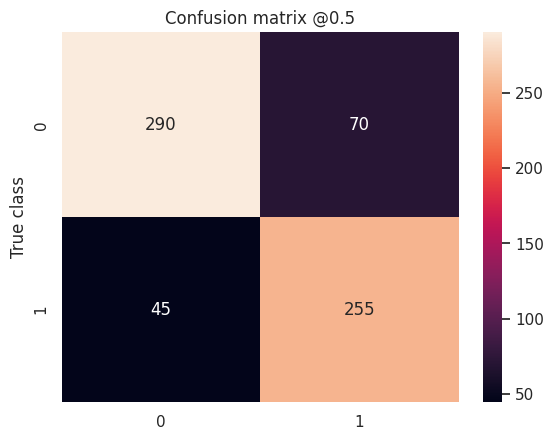

In [42]:
## plot confusion matrix
sns.heatmap(confustion_matrix, annot=True, fmt='d')
plt.title('Confusion matrix @0.5')
plt.ylabel('True class')

In [43]:
### Plot ROC and AUC
train_preds_ftxception, train_labels_ftxception = get_predictions_and_labels(trained_ftxception_model, augmented_train_generator)
validation_preds_ftxception, validation_labels_ftxception = get_predictions_and_labels(trained_ftxception_model, augmented_validation_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━

In [24]:
def plot_roc(name, labels, predictions, **kwargs):
    """ Function for plotting the ROC curve. """
    fp, tp, _ = metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 60])
    plt.ylim([20, 100.5])
    plt.grid(True)
    plt.title('ROC', fontsize=16)
    plt.legend(loc='lower right');


def plot_prc(name, labels, predictions, **kwargs):
    """ Function for plotting the area under the interpolated precision-recall curve (AUPRC). """
    precision, recall, _ = metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.title('AUPRC', fontsize=16);

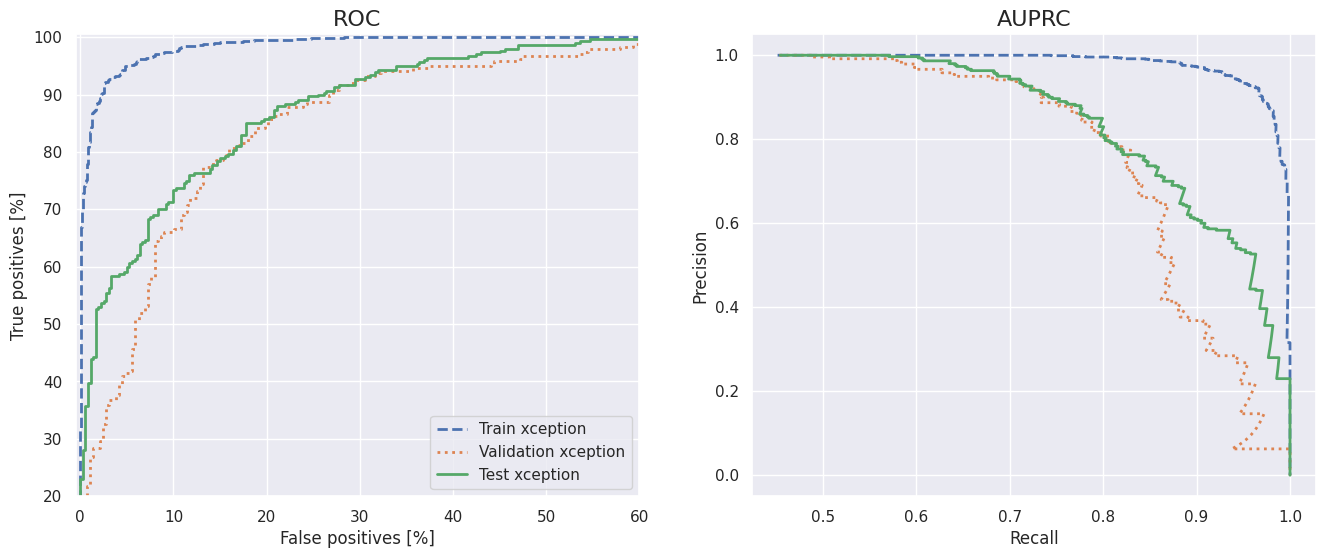

In [25]:
# Plot the ROC and AUPRC
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_roc('Train xception', train_labels_ftxception, train_preds_ftxception, linestyle='--')
plot_roc('Validation xception', validation_labels_ftxception, validation_preds_ftxception, linestyle=':')
plot_roc('Test xception', test_labels_ftxception, test_preds_ftxception)

plt.subplot(1, 2, 2)
plot_prc('Train xception', train_labels_ftxception, train_preds_ftxception, linestyle='--')
plot_prc('Validation xception', validation_labels_ftxception, validation_preds_ftxception, linestyle=':')
plot_prc('Test xception', test_labels_ftxception, test_preds_ftxception)